In [1]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz (14.8 MB)
  Preparing metadata (setup.py) ... done


In [2]:
!pip install gensim

# Pre-processing

Loading DATA

In [3]:
from pathlib import Path
import pandas as pd
DATA = Path("./data").expanduser()

assert DATA.is_dir()


x_df = pd.read_csv(
    DATA / "train.txt",
    delimiter='\t'
)
x_df = x_df.dropna()

x_df = x_df.reset_index()
x_df.columns = ['Label', 'Text']

In [4]:
x_df_test = pd.read_csv(
    DATA / "test.txt",
    delimiter= '\t'
)
x_df_test = x_df_test.dropna()

x_df_test = x_df_test.reset_index()
x_df_test.columns = ['Label', 'Text']

In [5]:
x_df_valid = pd.read_csv(
    DATA / "dev.txt",
    delimiter= '\t'
)
x_df_valid = x_df_valid.dropna()

x_df_valid = x_df_valid.reset_index()
x_df_valid.columns = ['Label', 'Text']

Data Reduction

In [6]:
# train
x_df_red =  x_df[:len(x_df)//200]

X_train = x_df["Text"]
y_train = x_df["Label"]

X_train_reduced = x_df_red["Text"]
y_train_reduced = x_df_red["Label"]

In [7]:
X_train.shape

(1777456,)

In [8]:
X_train_reduced.shape

(8887,)

In [9]:
# test
x_df_test_red =  x_df_test[:len(x_df_test)//15]

X_test = x_df_test["Text"]
y_test = x_df_test["Label"]

X_test_reduced = x_df_test_red["Text"]
y_test_reduced = x_df_test_red["Label"]

In [10]:
X_test.shape

(29493,)

In [11]:
X_test_reduced.shape

(1966,)

In [12]:
# valid
x_df_valid_red =  x_df_valid[:len(x_df_valid)//15]

X_valid = x_df_valid["Text"]
y_valid = x_df_valid["Label"]

X_valid_reduced = x_df_valid_red["Text"]
y_valid_reduced = x_df_valid_red["Label"]

In [13]:
X_valid.shape

(28932,)

In [14]:
X_valid_reduced.shape

(1928,)

Visualization of Data

In [15]:
import pandas as pd

# Compter le nombre d'instances par classe
class_counts = x_df_red["Label"].value_counts()
print(class_counts)

Label
RESULTS        3058
METHODS        2948
CONCLUSIONS    1383
BACKGROUND      816
OBJECTIVE       682
Name: count, dtype: int64


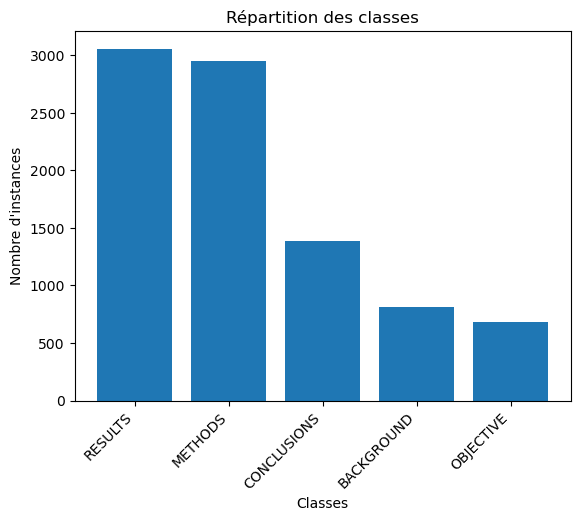

In [16]:
import matplotlib.pyplot as plt

# Visualiser le déséquilibre des classes
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Classes')
plt.ylabel('Nombre d\'instances')
plt.title('Répartition des classes')
plt.xticks(rotation=45, ha='right')
plt.show()

# Model 1 - using TF-IDF

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import string
import spacy

from spacy.lang.en.stop_words import STOP_WORDS


nlp = spacy.load("en_core_sci_sm")

2024-02-19 19:30:01.327015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [18]:
stop_words_list = list(STOP_WORDS)
#stop_words_list

In [19]:
def tokenizer_scii(text):
    tokens = nlp(text)
    return [(token.lemma_).lower() for token in tokens if token.text not in string.punctuation and token.text.lower() not in stop_words_list]

In [20]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer_scii, stop_words=stop_words_list)

In [21]:
X_train_tr = vectorizer.fit_transform(X_train_reduced)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'll', 'm', 've', '‘', '’'] not in stop_words.
  warnings.warn(


In [22]:
X_valid_tr = vectorizer.transform(X_valid_reduced)

In [23]:
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(X_train_tr.toarray(), columns=feature_names)

In [24]:
tfidf_df

,'',--,-.02,-0,-0.004,-0.01,-0.02,-0.03,-0.04,-0.05,...,zinc-containing,zinc-only,ziprasidone,zn,zn2,zolpidem,zone,zur,zurich,zusanli
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

def find_best_parameters(X_train, y_train, X_valid, y_valid):
    # Define the parameter grid to search
    param_grid = {'C': [0.1, 1, 10], 'max_iter': [50, 100, 200]}

    # Create the LinearSVC model
    model = LinearSVC()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Get the best model
    best_model = grid_search.best_estimator_

    # Make predictions on the validation set
    y_pred = best_model.predict(X_valid)

    # Calculate accuracy on the validation set
    accuracy = accuracy_score(y_valid, y_pred)

    return best_params, best_model, accuracy

best_params, best_model, accuracy = find_best_parameters(X_train_tr, y_train_reduced, X_valid_tr, y_valid)

#print("Best Parameters:", best_params)
#print("Validation Accuracy:", accuracy)


OSError: [Errno 12] Cannot allocate memory

Model 1 : Linear SVC

In [25]:
from sklearn.svm import LinearSVC

model = LinearSVC(C=0.3,max_iter=1000)
model.fit(X_train_tr, y_train_reduced)
pred = model.predict(X_valid_tr)

In [26]:
print(classification_report(y_valid_reduced, pred))
cm = confusion_matrix(y_valid_reduced, pred)

              precision    recall  f1-score   support

  BACKGROUND       0.43      0.31      0.36       140
 CONCLUSIONS       0.61      0.63      0.62       283
     METHODS       0.73      0.87      0.79       631
   OBJECTIVE       0.60      0.38      0.46       184
     RESULTS       0.81      0.79      0.80       690

    accuracy                           0.72      1928
   macro avg       0.64      0.59      0.61      1928
weighted avg       0.71      0.72      0.71      1928



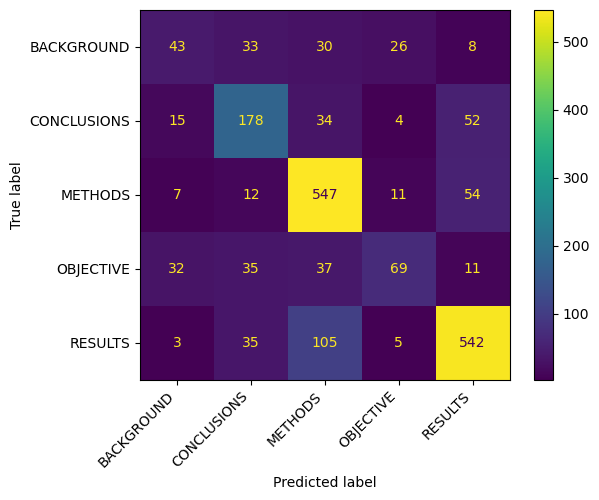

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

Model 2 : GradientBoostingClassifier

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

model2 = GradientBoostingClassifier(learning_rate=0.4,n_estimators=100, max_depth=2)
model2.fit(X_train_tr, y_train_reduced)
pred2 = model2.predict(X_valid_tr)

In [29]:
print(classification_report(y_valid_reduced, pred2))
cm2 = confusion_matrix(y_valid_reduced, pred2)

              precision    recall  f1-score   support

  BACKGROUND       0.32      0.24      0.27       140
 CONCLUSIONS       0.58      0.54      0.56       283
     METHODS       0.65      0.82      0.73       631
   OBJECTIVE       0.48      0.30      0.37       184
     RESULTS       0.77      0.73      0.75       690

    accuracy                           0.65      1928
   macro avg       0.56      0.52      0.53      1928
weighted avg       0.64      0.65      0.64      1928



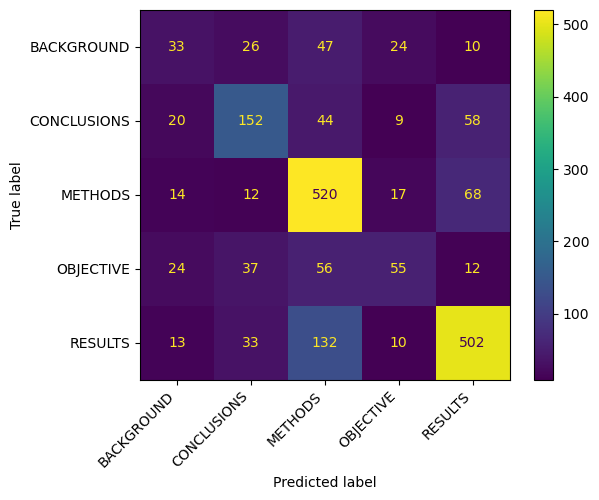

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=model2.classes_)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

Model 3 RandomForest

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Create and train the Random Forest classifier
model3 = RandomForestClassifier(n_estimators=1000, random_state=42)
model3.fit(X_train_tr, y_train_reduced)

# Make predictions on the validation set
pred3 = model3.predict(X_valid_tr)

# Evaluate the model
accuracy = accuracy_score(y_valid_reduced, pred3)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.674792531120332


**using another stopwords list**

We considered the potential influence of stopwords on the learning process of our model. Words such as 'from,' 'these,' and 'all' are commonly found in conclusions and results, and they might be overlooked due to the application of standard stopwords lists.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2
from collections import Counter
import numpy as np

vectorizer2 = TfidfVectorizer(tokenizer=tokenizer_scii)
X_train_tr = vectorizer2.fit_transform(X_train_reduced)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [33]:
modelsw2 = LinearSVC(C=0.1, max_iter=100)
modelsw2.fit(X_train_tr, y_train_reduced)

num_stopwords_per_category = 10

stopwords_per_category = {}
for category in modelsw2.classes_:
    category_index = np.where(modelsw2.classes_ == category)[0][0]

    features_chi2 = chi2(X_train_tr, y_train_reduced == category)[0]
    indices = np.argsort(features_chi2)

    least_frequent_terms = [vectorizer.get_feature_names_out()[i] for i in indices[:num_stopwords_per_category]]

    stopwords_per_category[category] = least_frequent_terms


In [34]:
custom_stop_words = []

for category, stopwords_list in stopwords_per_category.items():
    custom_stop_words += (stopwords_list)
    print(f"Stopwords for category '{category}': {', '.join(stopwords_list)}")
print(custom_stop_words)

Stopwords for category 'BACKGROUND': d-dimer, preenrollment, closed-loop, catheter-based, mtb-nave, prohormone, prognosis, adjustment, rbp4, productivity
Stopwords for category 'CONCLUSIONS': abi, revision, newborn, cetylpyridinium, familiarization, divergent, 5.7, train-of-4, gleason, igt
Stopwords for category 'METHODS': facility, cmha, stone, dibazole, nonadherence, entire, capsaicin, lmgb, kaempferol, viable
Stopwords for category 'OBJECTIVE': ami, ranibizumab-treated, positivity, dentinal, generic, pemphigus, administration, dawn, nephropathy, side-toxic
Stopwords for category 'RESULTS': likelihood, oa, cd19, driver, kg/m, usual-care, maladaptive, succinic, nine-month, tobacco-related
['d-dimer', 'preenrollment', 'closed-loop', 'catheter-based', 'mtb-nave', 'prohormone', 'prognosis', 'adjustment', 'rbp4', 'productivity', 'abi', 'revision', 'newborn', 'cetylpyridinium', 'familiarization', 'divergent', '5.7', 'train-of-4', 'gleason', 'igt', 'facility', 'cmha', 'stone', 'dibazole', '

In [35]:
vect2 = TfidfVectorizer(tokenizer=tokenizer_scii, stop_words=custom_stop_words)

In [36]:
X_train_tr2 = vect2.fit_transform(X_train_reduced)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [37]:
X_valid_tr2 = vect2.transform(X_valid_reduced)

In [38]:
feature_names = vect2.get_feature_names_out()

tfidf_df2 = pd.DataFrame(X_train_tr2.toarray(), columns=feature_names)

In [39]:
from sklearn.svm import LinearSVC

modelsw = LinearSVC(C=0.1,max_iter=100)
modelsw.fit(X_train_tr2, y_train_reduced)
predsw = modelsw.predict(X_valid_tr2)

In [40]:
print(classification_report(y_valid_reduced, predsw))
cmsw = confusion_matrix(y_valid_reduced, predsw)

              precision    recall  f1-score   support

  BACKGROUND       0.51      0.25      0.34       140
 CONCLUSIONS       0.62      0.61      0.62       283
     METHODS       0.68      0.88      0.77       631
   OBJECTIVE       0.62      0.30      0.41       184
     RESULTS       0.81      0.79      0.80       690

    accuracy                           0.71      1928
   macro avg       0.65      0.57      0.59      1928
weighted avg       0.70      0.71      0.69      1928



**Equilibrating the classes**

In [41]:
from sklearn.utils import resample

# Déterminer le nombre minimum d'échantillons parmi toutes les classes
min_samples = 1500

# Sous-échantillonnage des classes majoritaires
balanced_data = pd.concat([
    resample(x_df[x_df['Label'] == label], replace=False, n_samples=min_samples)
    for label in x_df['Label'].unique()
])

# Mélanger le DataFrame résultant
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)


In [42]:
import pandas as pd

# Compter le nombre d'instances par classe
balanced_class_counts = balanced_data["Label"].value_counts()
print(balanced_class_counts)

Label
BACKGROUND     1500
CONCLUSIONS    1500
RESULTS        1500
METHODS        1500
OBJECTIVE      1500
Name: count, dtype: int64


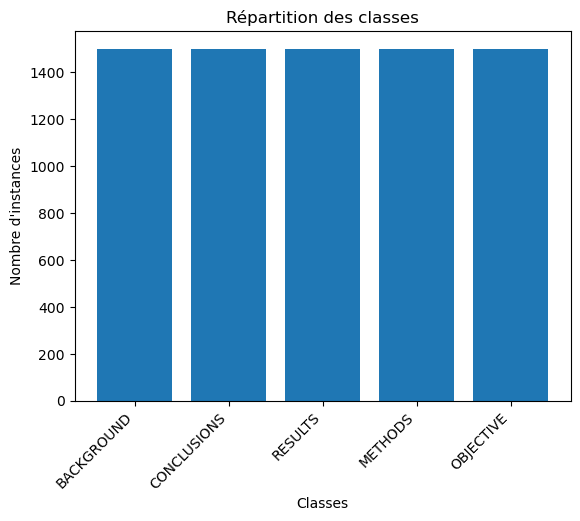

In [43]:
import matplotlib.pyplot as plt

# Visualiser le distribution des classes
plt.bar(balanced_class_counts.index, balanced_class_counts.values)
plt.xlabel('Classes')
plt.ylabel('Nombre d\'instances')
plt.title('Répartition des classes')
plt.xticks(rotation=45, ha='right')
plt.show()

In [44]:
# train
#x_df_balanced =  balanced_data[:(2*len(balanced_data)//3)]

X_train_balanced = balanced_data["Text"]
y_train_balanced = balanced_data["Label"]


In [45]:
y_train_balanced.shape

(7500,)

In [46]:
X_valid_reduced.shape

(1928,)

In [47]:
vectorizer2 = TfidfVectorizer(tokenizer=tokenizer_scii, stop_words=stop_words_list)
X_train_balanced_vec = vectorizer2.fit_transform(X_train_balanced)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'll', 'm', 've', '‘', '’'] not in stop_words.
  warnings.warn(


In [48]:
X_valid_balanced = vectorizer2.transform(X_valid_reduced)

In [49]:
X_train_balanced_vec.shape

(7500, 16439)

In [50]:
X_valid_tr.shape

(1928, 14117)

Linear SVC Model

In [51]:
from sklearn.svm import LinearSVC

model = LinearSVC(C=0.3,max_iter=100)
model.fit(X_train_balanced_vec, y_train_balanced)
pred = model.predict(X_valid_balanced)

In [52]:
print(classification_report(y_valid_reduced, pred))
cm = confusion_matrix(y_valid_reduced, pred)

              precision    recall  f1-score   support

  BACKGROUND       0.31      0.44      0.36       140
 CONCLUSIONS       0.56      0.62      0.59       283
     METHODS       0.78      0.76      0.77       631
   OBJECTIVE       0.42      0.56      0.48       184
     RESULTS       0.87      0.70      0.78       690

    accuracy                           0.68      1928
   macro avg       0.59      0.62      0.60      1928
weighted avg       0.71      0.68      0.69      1928



Random Forest Model

In [53]:

# Create and train the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_balanced_vec, y_train_balanced)

# Make predictions on the validation set
pred = model.predict(X_valid_balanced)


In [54]:
print(classification_report(y_valid_reduced, pred3))
cm2 = confusion_matrix(y_valid_reduced, pred3)

              precision    recall  f1-score   support

  BACKGROUND       0.54      0.15      0.23       140
 CONCLUSIONS       0.58      0.54      0.56       283
     METHODS       0.64      0.88      0.74       631
   OBJECTIVE       0.63      0.26      0.37       184
     RESULTS       0.77      0.76      0.76       690

    accuracy                           0.67      1928
   macro avg       0.63      0.52      0.53      1928
weighted avg       0.67      0.67      0.65      1928



Checking if i'm doing some overfitting 

In [55]:
pred_overfitting = model.predict(X_train_balanced_vec)

In [56]:
print(classification_report(y_train_balanced, pred_overfitting))
cm2 = confusion_matrix(y_train_balanced, pred_overfitting)

              precision    recall  f1-score   support

  BACKGROUND       1.00      1.00      1.00      1500
 CONCLUSIONS       1.00      1.00      1.00      1500
     METHODS       1.00      1.00      1.00      1500
   OBJECTIVE       1.00      1.00      1.00      1500
     RESULTS       1.00      1.00      1.00      1500

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



Regrettably, I am indeed encountering overfitting as a consequence of balancing my dataset. This is happening because my model is essentially memorizing the data rather than learning its underlying patterns.

**Other solution**

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=8000)
X_new = svd.fit_transform(X_train_tr)

In [ ]:

X_valid_new = svd.transform(X_valid_tr)

In [ ]:
from sklearn.svm import LinearSVC

model_pca = LinearSVC(C=0.3,max_iter=100)
model_pca.fit(X_new, y_train_reduced)
pred_pca = model_pca.predict(X_valid_new)

In [ ]:
print(classification_report(y_valid_reduced, pred_pca))
cm = confusion_matrix(y_valid_reduced, pred_pca)

In [ ]:
x_df_valid_red

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
import numpy as np



# Define a larger range of components to try
components_range = list(range(3000, 8000, 1000))

# Initialize an empty list to store mean accuracies
mean_accuracies = []

for n_components in components_range:
    # Create the TruncatedSVD object
    svd = TruncatedSVD(n_components=n_components)

    # Fit and transform on the training set
    X_train_new = svd.fit_transform(X_train_tr)

    # Train a classifier on the transformed training set
    model = LinearSVC()
    scores = cross_val_score(model, X_train_new, y_train_reduced, cv=5)  # 5-fold cross-validation

    # Store the mean accuracy in the list
    mean_accuracies.append(np.mean(scores))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(components_range, mean_accuracies, marker='o')
plt.title('TruncatedSVD Component Analysis')
plt.xlabel('Number of Components')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()


# Model 2 - using embeddings

In [57]:
from gensim.models import FastText, Word2Vec, KeyedVectors # KeyedVectors are used to load the GloVe models
import gensim

In [58]:
modelw2v = Word2Vec.load('../w2v_OA_CR_100d.bin')

**Creating a matrix of articals dimensions [100]**

In [59]:
from gensim.models import Word2Vec
import numpy as np

# Load Word2Vec biomedical model
def sentence_vector(sentence, model):
    # Split the sentence into words
    words = sentence.split()

    # Filter words that are present in the Word2Vec model
    valid_words = [word for word in words if word in model.wv]

    if not valid_words:
        # If no valid words are found, return a vector of zeros or handle it as needed
        return np.zeros(model.vector_size)

    # Calculate the average vector for the valid words
    avg_vector = np.mean([model.wv[word] for word in valid_words], axis=0)

    return avg_vector


1) With balanced data

In [60]:
#article_vectors2_train = [sentence_vector(article_tokens, modelw2v) for article_tokens in X_train_reduced]
article_vectors_train = [sentence_vector(article_tokens, modelw2v) for article_tokens in balanced_data["Text"]]

In [61]:
#article_vectors_valid = [get_article_vector(article_tokens) for article_tokens in X_valid_reduced]
article_vectors_valid = [sentence_vector(article_tokens, modelw2v) for article_tokens in X_valid_reduced]

In [62]:
from sklearn.svm import LinearSVC

model = LinearSVC(C=0.7,max_iter=200)
model.fit(article_vectors_train, balanced_data["Label"])
pred = model.predict(article_vectors_valid)

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_valid_reduced, pred))
cm = confusion_matrix(y_valid_reduced, pred)

              precision    recall  f1-score   support

  BACKGROUND       0.46      0.51      0.48       140
 CONCLUSIONS       0.61      0.68      0.64       283
     METHODS       0.80      0.77      0.79       631
   OBJECTIVE       0.50      0.61      0.55       184
     RESULTS       0.86      0.77      0.82       690

    accuracy                           0.73      1928
   macro avg       0.64      0.67      0.65      1928
weighted avg       0.74      0.73      0.73      1928



With Non balanced data

In [64]:
#article_vectors2_train = [sentence_vector(article_tokens, modelw2v) for article_tokens in X_train_reduced]
article_vectors2_train = [sentence_vector(article_tokens, modelw2v) for article_tokens in X_train_reduced]

In [65]:
#article_vectors2_valid = [sentence_vector(article_tokens, modelw2v) for article_tokens in X_valid_reduced]
article_vectors2_valid = [sentence_vector(article_tokens, modelw2v) for article_tokens in X_valid_reduced]

In [66]:
len(article_vectors2_valid[0])

100

In [67]:
model2 = LinearSVC(C=0.7,max_iter=1000)
model2.fit(article_vectors2_train, y_train_reduced)
pred2 = model2.predict(article_vectors2_valid)

In [68]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_valid_reduced, pred2))
cm = confusion_matrix(y_valid_reduced, pred2)

              precision    recall  f1-score   support

  BACKGROUND       0.50      0.36      0.41       140
 CONCLUSIONS       0.58      0.70      0.64       283
     METHODS       0.75      0.84      0.79       631
   OBJECTIVE       0.71      0.38      0.49       184
     RESULTS       0.81      0.80      0.81       690

    accuracy                           0.73      1928
   macro avg       0.67      0.62      0.63      1928
weighted avg       0.73      0.73      0.72      1928



In [69]:
from sklearn.ensemble import GradientBoostingClassifier

model_emb2 = GradientBoostingClassifier(learning_rate=0.4,n_estimators=100, max_depth=2)
model_emb2.fit(article_vectors2_train, y_train_reduced)
predemb2 = model_emb2.predict(article_vectors2_valid)

In [70]:
print(classification_report(y_valid_reduced, predemb2))
cm2 = confusion_matrix(y_valid_reduced, predemb2)

              precision    recall  f1-score   support

  BACKGROUND       0.43      0.47      0.45       140
 CONCLUSIONS       0.59      0.69      0.64       283
     METHODS       0.76      0.82      0.79       631
   OBJECTIVE       0.56      0.36      0.44       184
     RESULTS       0.84      0.79      0.81       690

    accuracy                           0.72      1928
   macro avg       0.64      0.63      0.63      1928
weighted avg       0.72      0.72      0.72      1928



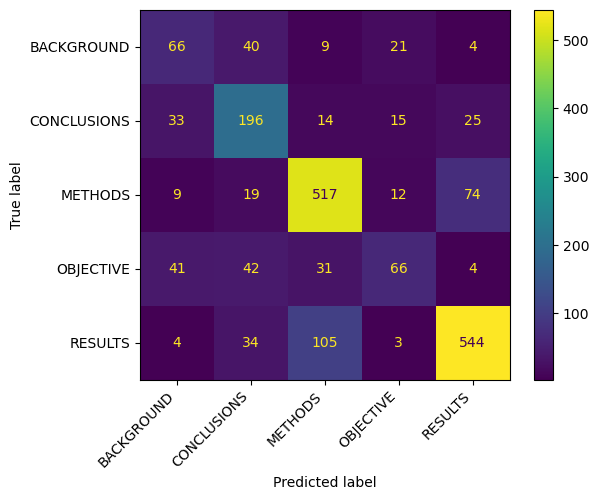

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=model2.classes_)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Create and train the Random Forest classifier
model_emb3 = RandomForestClassifier(n_estimators=100, random_state=42)
model_emb3.fit(article_vectors2_train, y_train_reduced)

# Make predictions on the validation set
pred_emb3 = model_emb3.predict(article_vectors2_valid)


In [73]:
print(classification_report(y_valid_reduced, pred_emb3))
cm2 = confusion_matrix(y_valid_reduced, pred_emb3)

              precision    recall  f1-score   support

  BACKGROUND       0.51      0.26      0.34       140
 CONCLUSIONS       0.56      0.73      0.63       283
     METHODS       0.69      0.87      0.77       631
   OBJECTIVE       0.64      0.17      0.27       184
     RESULTS       0.82      0.77      0.79       690

    accuracy                           0.70      1928
   macro avg       0.64      0.56      0.56      1928
weighted avg       0.70      0.70      0.68      1928



**Adding features to enhance the performance** 

1) Adding the sentence lenght as a supplement dimension 

In [74]:
def sentence_vector_with_length(sentence, model):
    # Split the sentence into words
    words = sentence.split()

    # Filter words that are present in the Word2Vec model
    valid_words = [word for word in words if word in model.wv]

    if not valid_words:
        # If no valid words are found, return a vector of zeros or handle it as needed
        return np.zeros(model.vector_size + 1)

    # Calculate the average vector for the valid words
    avg_vector = np.mean([model.wv[word] for word in valid_words], axis=0)

    # Add sentence length as an additional dimension
    sentence_length = len(words)
    vector_with_length = np.append(avg_vector, sentence_length)

    return vector_with_length



In [75]:
article_vectors_train_len = [sentence_vector_with_length(article_tokens, modelw2v) for article_tokens in X_train_reduced]

In [76]:
article_vectors_valid_len = [sentence_vector_with_length(article_tokens, modelw2v) for article_tokens in X_valid_reduced]

In [77]:
len(article_vectors_valid_len[0])

101

In [78]:
model_len = LinearSVC(C=0.5,max_iter=100)
model_len.fit(article_vectors_train_len, y_train_reduced)
pred_len = model_len.predict(article_vectors_valid_len)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [79]:
pred_len = model_len.predict(article_vectors_train_len)

print(classification_report(y_train_reduced, pred_len))
cm = confusion_matrix(y_train_reduced, pred_len)

              precision    recall  f1-score   support

  BACKGROUND       0.67      0.22      0.33       816
 CONCLUSIONS       0.41      0.80      0.54      1383
     METHODS       0.82      0.68      0.74      2948
   OBJECTIVE       0.88      0.01      0.02       682
     RESULTS       0.74      0.84      0.79      3058

    accuracy                           0.66      8887
   macro avg       0.70      0.51      0.49      8887
weighted avg       0.72      0.66      0.63      8887



In [80]:
model_len2 = RandomForestClassifier(n_estimators=120, random_state=42)
model_len2.fit(article_vectors_train_len, y_train_reduced)

# Make predictions on the validation set
pred_len2 = model_len2.predict(article_vectors_valid_len)


In [81]:
print(classification_report(y_valid_reduced, pred_len2))
cm = confusion_matrix(y_valid_reduced, pred_len2)

              precision    recall  f1-score   support

  BACKGROUND       0.53      0.24      0.33       140
 CONCLUSIONS       0.55      0.72      0.63       283
     METHODS       0.69      0.86      0.76       631
   OBJECTIVE       0.63      0.18      0.28       184
     RESULTS       0.82      0.77      0.79       690

    accuracy                           0.70      1928
   macro avg       0.64      0.55      0.56      1928
weighted avg       0.70      0.70      0.68      1928



2) Doing POS

In [82]:
# Get unique POS tags
unique_pos_tags = set()
def extract_pos_tags(sentence):
    doc = nlp(sentence)
    for token in doc:
        unique_pos_tags.add(token.pos_)

# Apply the function to dataset
X_train_reduced.apply(extract_pos_tags)

# Display the result
print(unique_pos_tags)

{'INTJ', 'SYM', 'VERB', 'PART', 'NUM', 'AUX', 'SCONJ', 'ADP', 'X', 'ADV', 'PRON', 'PUNCT', 'PROPN', 'NOUN', 'CCONJ', 'DET', 'ADJ'}


In [83]:
def sentence_vector_pos_tag(sentence, model, pos_tags_set):
    # Split the sentence into words
    words = sentence.split()

    # Filter words that are present in the Word2Vec model
    valid_words = [word for word in words if word in model.wv]

    if not valid_words:
        # If no valid words are found, return a vector of zeros or handle it as needed
        return np.zeros(model.vector_size + len(pos_tags_set))

    # Initialize vectors for word embeddings and POS tags
    word_vectors = [model.wv[word] for word in valid_words]
    pos_tag_vector = np.zeros(len(pos_tags_set))

    # Calculate the average vector for the valid words
    avg_vector = np.mean(word_vectors, axis=0)

    # Get POS tags for the sentence
    doc = nlp(sentence)
    pos_tags = [token.pos_ for token in doc]

    # Update POS tag vector based on the frequency in the set
    for pos_tag in pos_tags:
        if pos_tag in pos_tags_set:
            pos_tag_vector[list(pos_tags_set).index(pos_tag)] += 1

    # Concatenate word embeddings and POS tag vectors
    combined_vector = np.concatenate([avg_vector, pos_tag_vector])

    return combined_vector


Balanced DATA

In [84]:
article_vectors_train_Pos = [sentence_vector_pos_tag(article_tokens, modelw2v, unique_pos_tags) for article_tokens in balanced_data["Text"]]

In [85]:
article_vectors_valid_Pos = [sentence_vector_pos_tag(article_tokens, modelw2v, unique_pos_tags) for article_tokens in X_valid_reduced]

In [86]:
model_Pos = LinearSVC(C=0.3,max_iter=1000)
model_Pos.fit(article_vectors_train_Pos, balanced_data["Label"])
pred_Pos = model_Pos.predict(article_vectors_valid_Pos)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [87]:
print(classification_report(y_valid_reduced, pred_Pos))
cm = confusion_matrix(y_valid_reduced, pred_Pos)

              precision    recall  f1-score   support

  BACKGROUND       0.45      0.54      0.49       140
 CONCLUSIONS       0.60      0.70      0.65       283
     METHODS       0.80      0.79      0.80       631
   OBJECTIVE       0.53      0.57      0.55       184
     RESULTS       0.87      0.76      0.81       690

    accuracy                           0.73      1928
   macro avg       0.65      0.67      0.66      1928
weighted avg       0.74      0.73      0.73      1928



Imbalanced DATA

In [88]:
article_vectors_train_Pos2 = [sentence_vector_pos_tag(article_tokens, modelw2v, unique_pos_tags) for article_tokens in X_train_reduced]

In [89]:
article_vectors_valid_Pos2 = [sentence_vector_pos_tag(article_tokens, modelw2v, unique_pos_tags) for article_tokens in X_valid_reduced]

In [90]:
model_Pos2 = LinearSVC(C=0.3,max_iter=1200)
model_Pos2.fit(article_vectors_train_Pos2, y_train_reduced)
pred_Pos2 = model_Pos2.predict(article_vectors_valid_Pos2)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [91]:
print(classification_report(y_valid_reduced, pred_Pos2))
cm = confusion_matrix(y_valid_reduced, pred_Pos2)

              precision    recall  f1-score   support

  BACKGROUND       0.53      0.37      0.44       140
 CONCLUSIONS       0.61      0.71      0.66       283
     METHODS       0.76      0.85      0.80       631
   OBJECTIVE       0.71      0.45      0.55       184
     RESULTS       0.82      0.80      0.81       690

    accuracy                           0.74      1928
   macro avg       0.69      0.64      0.65      1928
weighted avg       0.74      0.74      0.73      1928

